In [62]:
import gzip
import pandas as pd
from collections import defaultdict
import math
import scipy.optimize
import numpy as np
import string
import random
from sklearn import linear_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.stem.porter import *
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
from sklearn.metrics import confusion_matrix, precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay


# Interactions Data

In [30]:
data_raw_interactions = pd.read_csv("RAW_interactions.csv")

In [31]:
data = data_raw_interactions.sample(50000, random_state = 42)
del data_raw_interactions

In [32]:
data.iloc[0,:]

user_id                                                 764278
recipe_id                                                32614
date                                                2012-12-22
rating                                                       5
review       I made these last night for a Christmas caroli...
Name: 592612, dtype: object

In [33]:
data['sentiment'] = data.apply(lambda row: 1 if row.rating in [5,4] else 0, axis=1)
data['sentiment'] = data.apply(lambda row: -1 if row.rating in [1,2] else row.sentiment, axis=1)

In [34]:
data['review'] = data['review'].astype(str)

### To do
1. BoW
2. Tf-idf
3. Spacy (cnn/svc?)


## 1. Bag of Words


In [27]:
stops = stopwords.words('english')

In [35]:
five_stars = data[data['rating'].isin([4,5])]['review']
one_stars = data[data['rating'].isin([1,2])]['review']


In [39]:
five_stars.iloc[0]

'I made these last night for a Christmas caroling party and they were devoured.  Amazing and simple!  Thanks for the recipe!'

In [36]:
def gen_wordcloud(data, max_words, stopwords):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = max_words,
        stopwords = stopwords,
        max_font_size = 40, 
        scale = 3,
        random_state = 1
    ).generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()

In [44]:
#%pip install textblob
from textblob import TextBlob
five_stars['blobbed'] = five_stars.apply(lambda x: TextBlob(str(x)).words)
five_stars['cleaned'] = five_stars['blobbed'].apply(lambda x: list(set(x.lower()) - set(stops)))

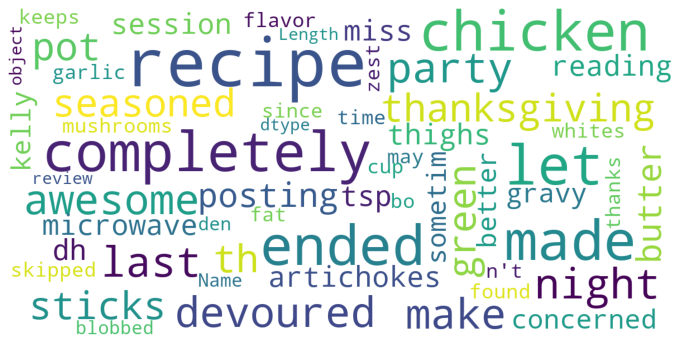

In [48]:
gen_wordcloud(five_stars['cleaned'], 200, stops)

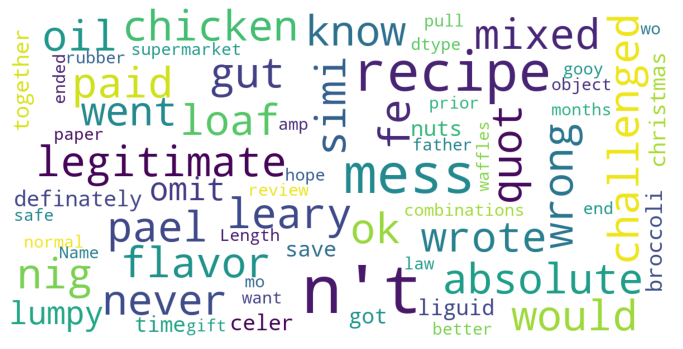

In [49]:
one_stars['blobbed'] = one_stars.apply(lambda x: TextBlob(str(x)).words)
one_stars['cleaned'] = one_stars['blobbed'].apply(lambda x: list(set(x.lower()) - set(stops)))
gen_wordcloud(one_stars['cleaned'], 200, stops)

In [ ]:
del five_stars, one_stars

In [50]:
data['polarity'] = data['review'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
data.head()

,user_id,recipe_id,date,rating,review,sentiment,polarity
592612,764278,32614,2012-12-22,5,I made these last night for a Christmas caroli...,1,0.212500
613724,51546,57355,2008-12-27,5,These are awesome! I made them for Thanksgivi...,1,0.625000
877117,133174,241394,2007-08-06,4,This completely filled a 3 qt crock pot. I se...,1,0.150000
269484,1134625,169227,2010-05-11,5,"i made this with 6 boneless skinless thighs, l...",1,0.383333
366684,51011,121093,2006-09-26,5,I really loved this sauce. I ended up using c...,1,0.110000


In [51]:
data['polarity_norm'] = data['review'].apply(lambda x: math.ceil(TextBlob(str(x)).sentiment.polarity))

In [52]:
print(data['polarity_norm'].value_counts())
print(data['sentiment'].value_counts())

 1    46727
 0     3260
-1       13
Name: polarity_norm, dtype: int64
 1    44183
 0     4640
-1     1177
Name: sentiment, dtype: int64


0.86154 0.8334309773636922
0.8472524117843296


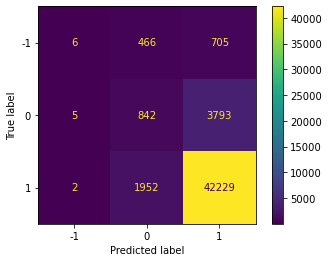

In [65]:
precision = precision_score(data['sentiment'], data['polarity_norm'], average = 'weighted')
recall = recall_score(data['sentiment'], data['polarity_norm'], average = 'weighted')
print(recall, precision)
f1_score = 2*precision*recall/(precision+recall)
print(f1_score)
ConfusionMatrixDisplay.from_predictions(data['sentiment'], data['polarity_norm'])

# Recipe Data

In [19]:
data_raw_recipe = pd.read_csv("RAW_recipes.csv")
data_raw_recipe = data_raw_recipe.sample(50000, random_state = 42)

In [20]:
data_raw_recipe['name_ingredients_tags'] =  data_raw_recipe["name"].astype(str) + " " + \
        data_raw_recipe["ingredients"] + " " +data_raw_recipe["tags"]

In [21]:
data_raw_recipe.iloc[0,:]

name                                           crab filled crescent snacks
id                                                                   94947
minutes                                                                 70
contributor_id                                                      111448
submitted                                                       2004-07-03
tags                     ['time-to-make', 'course', 'main-ingredient', ...
nutrition                             [69.2, 3.0, 9.0, 6.0, 5.0, 4.0, 3.0]
n_steps                                                                 16
steps                    ['heat over to 375 degrees', 'spray large cook...
description                      found in a crescent roll recipe magazine.
ingredients              ['crabmeat', 'cream cheese', 'green onions', '...
n_ingredients                                                            9
name_ingredients_tags    crab filled crescent snacks ['crabmeat', 'crea...
Name: 59957, dtype: objec